In [40]:
import os
import pandas as pd 
import numpy as np 
import subprocess
import math
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import dataframe_image as dfi

import matplotlib.pyplot as plt 
from matplotlib.patches import Patch
import matplotlib.cm 
import matplotlib.colors 
plt.rcParams['font.family'] = 'Arial'

from selenobot.files import FASTAFile, fasta_file_parser_gtdb, GBFFFile, BLASTFile
from selenobot.tools import BLAST
from selenobot.gene import Gene, Genome
from selenobot.organism import Organism

%load_ext autoreload 
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Based on analyzing the results of the binary model on the model organisms, it seems as though the majority of the false positives are due to the model mistakenly identifying short Prodigal artifacts and pseudogenes as truncated selenoproteins. It also seems prone to predicting short hypothetical proteins (which I imagine are artifacts from PGAP) to be truncated selenoproteins. 

However, sequence length is not the *only* determining factor, as many of the short sequences in all categories are not predicted to be truncated selenoproteins. 

In [16]:
species = ['Pseudomonas aeruginosa', 'Escherichia coli', 'Mycobacterium tuberculosis', 'Bacillus subtilis', 'Aliivibrio fischeri'] 

# Using the genomes from the GTDB species representative for release r207.
genome_ids = dict() 
genome_ids['Pseudomonas aeruginosa'] = 'GCF_001457615.1'
genome_ids['Bacillus subtilis'] = 'GCF_000009045.1'
genome_ids['Escherichia coli'] = 'GCF_000195955.2'
genome_ids['Mycobacterium tuberculosis'] = 'GCF_003697165.2'
genome_ids['Aliivibrio fischeri'] = 'GCF_016464335.1'

# genome_metadata_df = pd.read_csv('../data/gtdb_genome_metadata_bacteria.csv', index_col=0)
# genome_metadata_df = genome_metadata_df[genome_metadata_df.species.isin(species)]

In [17]:
if (not os.path.exists('../data/model_organisms/organisms.pkl')):
    organisms = list()
    for species in genome_ids.keys():
        print(f'\n{species}')
        organism = Organism(genome_ids[species], species)
        organism.label()
        organisms.append(organism)
    with open('../data/model_organisms/organisms.pkl', 'wb') as f:
        pickle.dump(organisms, f)
else:
    with open('../data/model_organisms/organisms.pkl', 'rb') as f:
        organisms = pickle.load(f)


def make_summary_table(path='../data/model_organisms/summary_table.png'):   
    table_df = list()
    for organism in organisms:
        row = dict()
        row['species'] = organism.species
        row['ref. genome size'] = organism.size(source='ncbi', pseudo=False)
        row['GTDB genome size'] = organism.size(source='gtdb')
        row['num. pseudogenes'] = organism.size(source='ncbi', pseudo=True)
        table_df.append(row)
    table_df = pd.DataFrame(table_df).set_index('species')
    dfi.export(table_df, path)

# make_summary_table()

In [19]:
usecols = ['ternary_model_plm_prediction', 'binary_model_plm_prediction'] 
pred_df = list()
for organism in organisms:
    df = pd.read_csv(f'../data/results/gtdb_{organism.code_name}.predict.csv', index_col=0)[usecols]
    df = df.merge(organism.to_df(), left_index=True, right_index=True, how='left')
    pred_df.append(df)
pred_df = pd.concat(pred_df)
pred_df = pred_df[pred_df.binary_model_plm_prediction == 1] # Look at the positive cases for now..

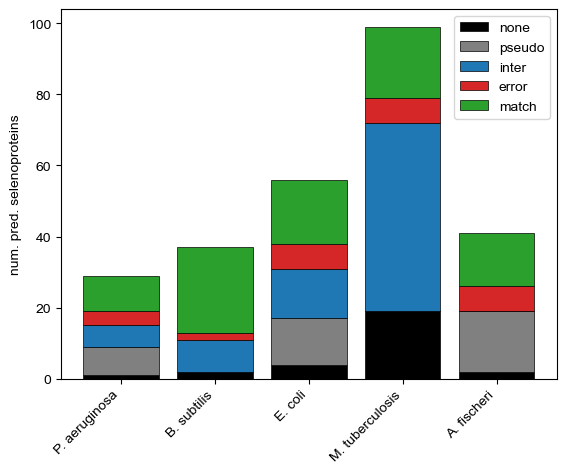

In [20]:
fig, ax = plt.subplots()

color_map = {'match':'tab:green', 'error':'tab:red', 'inter':'tab:blue', 'pseudo':'gray', 'none':'black'}
labels = ['none', 'pseudo', 'inter', 'error', 'match']
species = list(genome_ids.keys()) 

bottom = np.zeros(len(labels))
for label in labels:
    label_df = pred_df[pred_df.label == label]
    heights = np.array([(label_df.species == s).sum() for s in species])
    ax.bar(np.arange(len(species)), heights, bottom=bottom, color=color_map[label], edgecolor='black', linewidth=0.5)
    bottom += heights

ax.set_xticks(np.arange(len(species)), labels=[f'{s.split()[0][0]}. {s.split()[-1]}' for s in species], rotation=45, ha='right')
ax.legend(labels)
ax.set_ylabel('num. pred. selenoproteins')
plt.show()

# I think a lot of the intergenic genes are probably pseudogenes... 


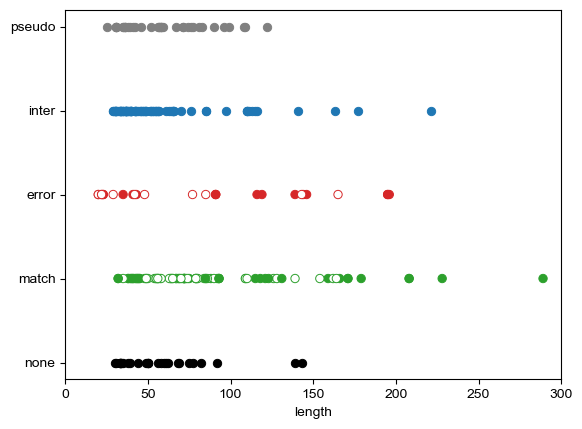

In [21]:
fig, ax = plt.subplots()

info_dfs = dict()
info_dfs['match'] = pd.concat([organism.get_match_info() for organism in organisms]) 
info_dfs['error'] = pd.concat([organism.get_error_info() for organism in organisms]) 

labels = ['none', 'match', 'error', 'inter', 'pseudo']
for i, label in enumerate(labels):
    df = pd.concat([organism.to_df(label=label) for organism in organisms]) 
    df = df[df.index.isin(pred_df.index)]

    color = color_map[label]
    if label in info_dfs:
        info_df = info_dfs[label]
        info_df = info_df[info_df.index.isin(df.index)]
        color = [color_map[label] if ('hypothetical' not in prod) else 'white' for prod in info_df['product']]

    ax.scatter(df.seq.apply(len), [i] * len(df), edgecolor=color_map[label], linewidths=0.7, color=color)

ax.set_xlim(0, 300)
ax.set_yticks(np.arange(len(labels)), labels=labels)
ax.set_xlabel('length')

plt.show()



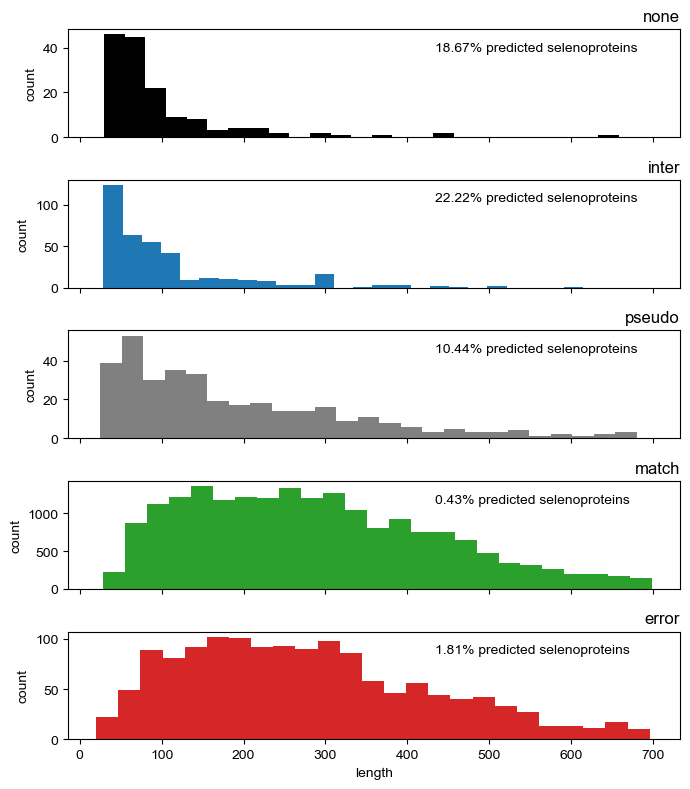

In [22]:
fig, axes = plt.subplots(nrows=5, figsize=(7, 8), sharex=True)

max_length = 700
labels = ['none', 'inter', 'pseudo', 'match', 'error']
for ax, label in zip(axes, labels):
    df = pd.concat([organism.to_df(label=label) for organism in organisms]) 

    p = f'{100 * df.index.isin(pred_df.index).sum() / len(df):.2f}% predicted selenoproteins'
    ax.text(0.6, 0.8, p, transform=ax.transAxes)

    lengths = df.seq.apply(len)
    lengths = lengths[lengths < max_length]
    ax.hist(lengths, color=color_map[label], bins=25)
    ax.set_ylabel('count')
    ax.set_title(label, loc='right')

ax.set_xlabel('length')
plt.tight_layout()
plt.show()

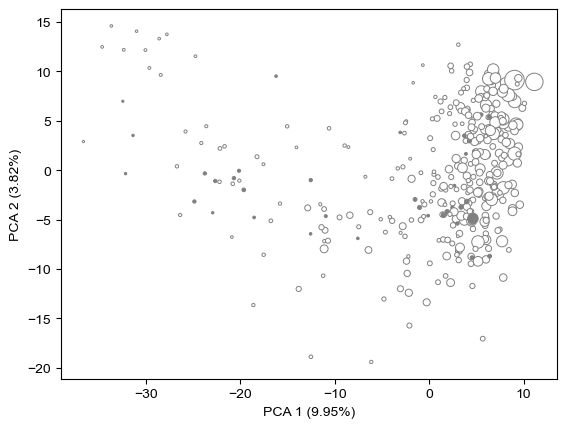

In [52]:
def load_embeddings(label:str):
    '''Load in the PLM embeddings which correspond to sequences with a specific label.'''
    ids = np.concatenate([organism.to_df(label=label).index for organism in organisms])

    emb_df = []
    seqs = []
    for organism in organisms:
        df = pd.read_hdf(f'../data/model_organisms/gtdb_{organism.code_name}.h5', key='plm')
        seq_df = pd.read_hdf(f'../data/model_organisms/gtdb_{organism.code_name}.h5', key='metadata')[['seq']]
        
        mask = df.index.isin(ids) 
        emb_df.append(df[mask])
        seqs += list(seq_df[mask].values.ravel())
    emb_df = pd.concat(emb_df)

    return emb_df, seqs



fig, ax = plt.subplots()

label = 'pseudo'
emb_df, seqs = load_embeddings(label)
emb, index = emb_df.values, emb_df.index

scaler = StandardScaler()
emb = scaler.fit_transform(emb)
pca = PCA(n_components=2)
comps = pca.fit_transform(emb)

exp_var = pca.explained_variance_ratio_
ax.set_xlabel(f'PCA 1 ({100 * exp_var[0]:.2f}%)')
ax.set_ylabel(f'PCA 2 ({100 * exp_var[1]:.2f}%)')

colors = [color_map[label] if id_ in pred_df.index else 'white' for id_ in index]
sizes = [len(seq) / 10 for seq in seqs]
ax.scatter(comps[:, 0], comps[:, 1], edgecolors=color_map[label], linewidth=0.7, color=colors, sizes=sizes)
plt.show()

